# О проекте


Задание относится к проекту UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 


## Цель проекта

Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Средства достижения целей

Реализовать достижение целей можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы.

## Задача проекта

Чтобы определиться с параметрами будущей модели, нужно провести разведывательный анализ данных и составьте отчёт по его результатам.

## Импорт библиотек

In [7]:
import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import os
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from itertools import combinations

from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats import weightstats 


%matplotlib inline

### Инструменты для предобработки

In [121]:
# 
def column_content_analysis(column_name_list, column_type='str', more_than = 10):
    '''
        Функция для определения типовых параметров данных, а также определние "замусоренности".
        На вход принимает список столбцов датафрейма
    '''
    # проходим циклом по списку колонок    
    for column_name in column_name_list:
        print('-'*60)
        print('|\t' , 'Отчет по колонке [', column_name, ']', '\t'*5)
        print('-'*60)
        if column_name not in stud.columns:
            print('|  Внимание!!! Указанная колонка не найдена в датасете. \n')
            break

        col_count = stud[column_name].count()
        col_type = stud[column_name].dtype
        print('|  Тип данных:', col_type) 
        print('|  Заполнено значений:',  col_count, 'из', row_count)
        print('|  Отсутсвующие значения:', row_count - col_count)
        print('|  Полнота данных: ', round(col_count / row_count * 100 ,2), '%', sep='')
        print('|  Количество уникальных значений:', stud[column_name].nunique())

        print('|  Значений, встретившихся в столбце более', more_than,'раз:', 
              (stud[column_name].value_counts() > more_than).sum())

        if col_type == 'object':
            # Количество пробелов в начале в конце строки
            print('|  Количество раз пробелы найдены:')
            find_list = [len(re.findall(r'^\s+\w?', str(x))) for x in stud[column_name]]
            print('|    в начале строки:', sum(find_list))
            
            find_list = [len(re.findall(r'\w?\s+$', str(x))) for x in stud[column_name]]
            print('|    в конце  строки:', sum(find_list))
            
            find_list = [len(re.findall(r'[^\s\d\w]', str(x))) for x in stud[column_name]]
            print('|  Количество найденных специальных символов:', sum(find_list))
        
        if col_type in ['int', 'float']:
            print('|  Медиана: ', stud[column_name].median())
            # perc25 = stud[column_name].quantile(0.25)
            perc25 = stud[column_name].describe().loc['25%']
            # perc75 = stud[column_name].quantile(0.75)
            perc75 = stud[column_name].describe().loc['75%']
            iqr = perc75 - perc25
            range_left = perc25 - 1.5 * iqr
            range_right = perc75 + 1.5 * iqr
            # print('|  25-й перцентиль:', round(perc25, 2))
            # print('|  75-й перцентиль:', round(perc75, 2))
            # Границы выбросов
            print('|  IQR: ', iqr, '; границы выбросов: [', round(range_left, 2), '; ', round(range_right,2),']' , sep='')
            out_of_range_left = stud[column_name].loc[stud[column_name] < range_left]
            out_of_range_right = stud[column_name].loc[stud[column_name] > range_right]
            out_of_range = len(out_of_range_left) + len(out_of_range_right)
            if out_of_range > 0:
                print('|  Данные СОДЕРЖАТ выбросы, количество значений: ', out_of_range)
                if len(out_of_range_left) > 0:
                    print('|    Слева  от IQR (уникальные):', out_of_range_left.unique())
                if len(out_of_range_right) > 0:
                    print('|    Справа от IQR (уникальные):', out_of_range_right.unique())
         
        print('|---\n|  Все уникальные значения:', stud[column_name].unique() , '\n')
        

    # end function



# column_content_analysis(['age'])



------------------------------------------------------------
|	 Отчет по колонке [ age ] 					
------------------------------------------------------------
|  Тип данных: int64
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 8
|  Значений, встретившихся в столбце более 10 раз: 5
|  Медиана:  17.0
|  IQR: 2.0; границы выбросов: [13.0; 21.0]
|  Данные СОДЕРЖАТ выбросы, количество значений:  1
|    Справа от IQR (уникальные): [22]
|---
|  Все уникальные значения: [18 17 15 16 19 22 20 21] 



In [9]:
# 
def column_iqr_range(column_name):
    '''
        Функция для расчета промежутка IQR
    '''
    if column_name in stud.columns and stud[column_name].dtype in ['int', 'float']:
        perc25 = stud[column_name].describe().loc['25%']
        perc75 = stud[column_name].describe().loc['75%']
        iqr = perc75 - perc25
        range_left = perc25 - 1.5 * iqr
        range_right = perc75 + 1.5 * iqr
        return range_left, range_right
    else:
        return None
        # out_of_range_left = stud[column_name].loc[stud[column_name] < range_left]
        # out_of_range_right = stud[column_name].loc[stud[column_name] > range_right]
        # out_of_range = len(out_of_range_left) + len(out_of_range_right)


    # end function



### Загрузка первичных данных

In [10]:
# 
incoming_files = 'stud_math.csv'

# 
if incoming_files not in os.listdir():
    print('\n!!! ВНИМАНИЕ !!!'*5)
    print('Не найден входной файл данных:', incoming_files)
    incoming_files = r'/content/drive/My Drive/Colab Notebooks/module_2/stud_math.csv'
else:
    print(r'[OK] Успешно пройдена проверка наличия входного файла датасета.')



!!! ВНИМАНИЕ !!!
!!! ВНИМАНИЕ !!!
!!! ВНИМАНИЕ !!!
!!! ВНИМАНИЕ !!!
!!! ВНИМАНИЕ !!!
Не найден входной файл данных: stud_math.csv


In [11]:
# 
stud = pd.read_csv(incoming_files)

# 
row_count, col_count = stud.shape



In [12]:
print('Количество строк датасета:', row_count,'\nКоличество столбцов датасета:', col_count)

Количество строк датасета: 395 
Количество столбцов датасета: 30


In [13]:
# показывать больше строк
pd.set_option('display.max_rows', 50)

# показывать больше колонок
pd.set_option('display.max_columns', col_count + 5) 

### Первичный осмотр данных

In [14]:
stud.sample(9)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
319,GP,F,18,U,GT3,T,4.0,4.0,teacher,other,course,mother,1.0,2.0,0.0,no,yes,NaN,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,5.0,2.0,55.0
385,MS,F,18,R,GT3,T,2.0,2.0,at_home,other,other,NaN,NaN,3.0,0.0,no,no,yes,no,yes,-9.0,yes,NaN,no,5.0,3.0,3.0,4.0,2.0,50.0
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,NaN,2.0,1.0,no,no,no,yes,yes,-6.0,yes,NaN,no,1.0,1.0,1.0,5.0,0.0,0.0
273,GP,M,17,R,GT3,T,1.0,2.0,at_home,at_home,home,mother,1.0,2.0,0.0,no,yes,yes,yes,no,-6.0,yes,NaN,yes,3.0,5.0,2.0,1.0,2.0,70.0
325,GP,M,18,U,GT3,T,4.0,4.0,other,other,course,mother,1.0,3.0,0.0,no,no,no,yes,yes,-9.0,yes,yes,no,4.0,3.0,3.0,3.0,3.0,55.0
225,GP,F,18,R,GT3,T,3.0,1.0,other,other,reputation,mother,1.0,2.0,1.0,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,4.0,16.0,35.0
193,GP,M,16,R,GT3,NaN,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
336,GP,F,19,R,GT3,A,3.0,1.0,services,NaN,home,other,1.0,3.0,1.0,no,no,yes,no,NaN,-9.0,yes,no,no,5.0,4.0,3.0,5.0,12.0,65.0
251,GP,M,16,U,GT3,T,3.0,3.0,at_home,other,reputation,other,3.0,2.0,0.0,yes,yes,no,no,no,-6.0,yes,NaN,no,5.0,3.0,3.0,2.0,6.0,50.0


In [15]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [16]:
stud.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

В названиях колонок встречается написание с большой буквы, далее приведем все имена колонок к нижнему регистру.

### Первичная обработка данных

In [17]:
# Удаляем столбец не заявленный в описании
if 'studytime, granular' in stud.columns:
    stud.drop(['studytime, granular'], inplace=True, axis = 1)

# приводим все названия колонок к нижнему регистру
stud.columns = [str.lower(x) for x in stud.columns]

# получаем список всех колонок
all_columns = stud.columns

In [18]:
# dtypes: float64(11), int64(1), object(17)

dig_columns = ['age','medu', 'fedu', 'traveltime', 'studytime', 'failures',
              'famrel', 'freetime', 'goout', 'health', 'absences', 'score']

stud.loc[:, dig_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         395 non-null    int64  
 1   medu        392 non-null    float64
 2   fedu        371 non-null    float64
 3   traveltime  367 non-null    float64
 4   studytime   388 non-null    float64
 5   failures    373 non-null    float64
 6   famrel      368 non-null    float64
 7   freetime    384 non-null    float64
 8   goout       387 non-null    float64
 9   health      380 non-null    float64
 10  absences    383 non-null    float64
 11  score       389 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 37.2 KB


In [19]:
# 
other_columns = [x for x in all_columns if x not in dig_columns]
other_columns

['school',
 'sex',
 'address',
 'famsize',
 'pstatus',
 'mjob',
 'fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [20]:
# произведем замену пустых значений и значений nan в строковых столбцах
for col_name in other_columns:
    stud[col_name] = stud[col_name].apply(lambda x : None if pd.isnull(x)
                                    else None if str.lower(x) == 'nan'
                                    else None if x.strip == ''
                                    else x.strip())

In [21]:
# column_content_analysis(['address', 'age', 'medu'])

column_content_analysis(all_columns)

------------------------------------------------------------
|	 Отчет по колонке [ school ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['GP' 'MS'] 

------------------------------------------------------------
|	 Отчет по колонке [ sex ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных спе

In [22]:
# выведем результат первичной обработки
stud.sample(9)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
378,MS,F,18,U,GT3,T,3.0,3.0,other,other,home,mother,1.0,2.0,0.0,no,no,yes,no,yes,yes,yes,yes,4.0,1.0,3.0,1.0,0.0,75.0
330,GP,M,18,U,LE3,T,2.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,yes,no,yes,yes,yes,yes,None,4.0,5.0,5.0,NaN,2.0,40.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,None,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
124,GP,F,16,U,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,yes,no,yes,yes,yes,yes,5.0,4.0,4.0,5.0,0.0,40.0
203,GP,F,17,R,GT3,T,2.0,2.0,other,other,reputation,mother,1.0,1.0,0.0,no,yes,no,no,yes,yes,yes,no,5.0,3.0,2.0,3.0,18.0,30.0
366,MS,M,18,U,LE3,T,4.0,4.0,teacher,services,other,mother,2.0,3.0,0.0,no,no,yes,no,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,65.0
63,GP,F,16,U,GT3,None,4.0,3.0,teacher,health,None,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
358,MS,M,18,U,LE3,T,1.0,1.0,other,services,home,father,2.0,1.0,0.0,no,no,no,no,no,yes,yes,yes,3.0,3.0,2.0,3.0,4.0,50.0
360,MS,F,18,R,None,A,1.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,no,no,yes,yes,no,yes,NaN,3.0,4.0,5.0,0.0,65.0


## Распределение признака для числовых переменных

In [23]:
# количество числовых столбцов
len(dig_columns)

12

In [24]:
# список числовых столбцов
dig_columns

['age',
 'medu',
 'fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences',
 'score']

In [25]:
# список и расширенная информация для числовых столбцов
stud.loc[:, dig_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         395 non-null    int64  
 1   medu        392 non-null    float64
 2   fedu        371 non-null    float64
 3   traveltime  367 non-null    float64
 4   studytime   388 non-null    float64
 5   failures    373 non-null    float64
 6   famrel      368 non-null    float64
 7   freetime    384 non-null    float64
 8   goout       387 non-null    float64
 9   health      380 non-null    float64
 10  absences    383 non-null    float64
 11  score       389 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 37.2 KB


### age

age — возраст ученика (от 15 до 22)

In [26]:
column_content_analysis(['age'])

------------------------------------------------------------
|	 Отчет по колонке [ age ] 					
------------------------------------------------------------
|  Тип данных: int64
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 8
|  Значений, встретившихся в столбце более 10 раз: 5
|  IQR: 2.0; границы выбросов: [13.0; 21.0]
|  Данные СОДЕРЖАТ выбросы, количество значений:  1
|    Справа от IQR (уникальные): [22]
|
|  Все уникальные значения: [18 17 15 16 19 22 20 21] 



* Колонка не содержит пустых значений.
* Есть 1 выброс данных.
* Значение выброса `22` в ходит допустимый диапазон, поэтому фильтрация не потребуется.

In [138]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['age'].value_counts()).sort_index())

,age
15,82
16,104
17,98
18,82
19,24
20,3
21,1
22,1


In [28]:
stud['age'].describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

In [29]:
# stud['age'].describe().loc['25%'], stud['age'].describe().loc['75%']

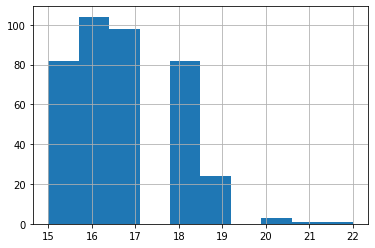

In [30]:
stud['age'].hist()

### medu

Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [123]:
column_content_analysis(['medu'])

------------------------------------------------------------
|	 Отчет по колонке [ medu ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 392 из 395
|  Отсутсвующие значения: 3
|  Полнота данных: 99.24%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 4
|  Медиана:  3.0
|  IQR: 2.0; границы выбросов: [-1.0; 7.0]
|---
|  Все уникальные значения: [ 4.  1.  3.  2. nan  0.] 



* Колонка содержит только 3 пустых значения. 
* Качество данных хорошее.
* Выбросов не обнаружено.

In [32]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['medu'].value_counts()))

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


In [33]:
stud['medu'].describe()

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

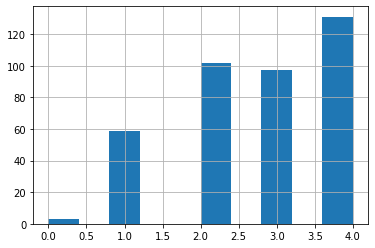

In [34]:
stud['medu'].hist()

### fedu

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [35]:
column_content_analysis(['fedu'])

------------------------------------------------------------
|	 Отчет по колонке [ fedu ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 371 из 395
|  Отсутсвующие значения: 24
|  Полнота данных: 93.92%
|  Количество уникальных значений: 6
|  Значений, встретившихся в столбце более 10 раз: 4
|  IQR: 1.0; границы выбросов: [0.5; 4.5]
|  Данные СОДЕРЖАТ выбросы, количество значений:  3
|    Слева  от IQR (уникальные): [0.]
|    Справа от IQR (уникальные): [40.]
|
|  Все уникальные значения: [ 4.  1.  2.  3. 40. nan  0.] 



In [36]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['fedu'].value_counts()))

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


In [37]:
stud['fedu'].describe()

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

* Колонка содержит пустые значения - `24` шт. 
* Качество данных нормальное.
* Обнаружен выброс данных (значение `40`). Это явная опечатка, можно скорректировать до `4`.
* Значение `0`, меньшей левой границы - попадае в рамки начальных условий.

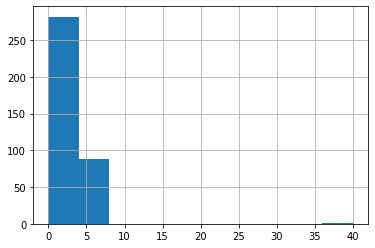

In [38]:
stud['fedu'].hist()

### traveltime

traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [39]:
column_content_analysis(['traveltime'])

------------------------------------------------------------
|	 Отчет по колонке [ traveltime ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 367 из 395
|  Отсутсвующие значения: 28
|  Полнота данных: 92.91%
|  Количество уникальных значений: 4
|  Значений, встретившихся в столбце более 10 раз: 3
|  IQR: 1.0; границы выбросов: [-0.5; 3.5]
|  Данные СОДЕРЖАТ выбросы, количество значений:  7
|    Справа от IQR (уникальные): [4.]
|
|  Все уникальные значения: [ 2.  1.  3. nan  4.] 



In [40]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['traveltime'].value_counts()))

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


In [41]:
stud['traveltime'].describe()

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

* Колонка содержит пустые значения - 28 шт. 
* Качество данных нормальное.
* Обнаружен выброс данных, но в пределах допустимого.

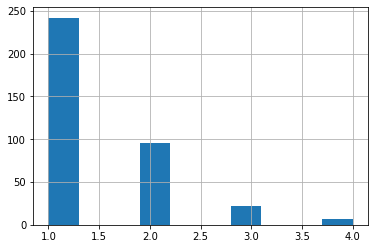

In [42]:
stud['traveltime'].hist()

### studytime

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [43]:
column_content_analysis(['studytime'])

------------------------------------------------------------
|	 Отчет по колонке [ studytime ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 388 из 395
|  Отсутсвующие значения: 7
|  Полнота данных: 98.23%
|  Количество уникальных значений: 4
|  Значений, встретившихся в столбце более 10 раз: 4
|  IQR: 1.0; границы выбросов: [-0.5; 3.5]
|  Данные СОДЕРЖАТ выбросы, количество значений:  27
|    Справа от IQR (уникальные): [4.]
|
|  Все уникальные значения: [ 2.  3.  1. nan  4.] 



In [44]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['studytime'].value_counts()))

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


In [45]:
stud['studytime'].describe()

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

* Колонка содержит пустые значения - 7 шт. 
* Качество данных хорошее.
* Обнаружен выброс данных, но в пределах допустимого.

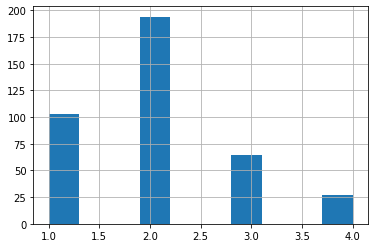

In [46]:
stud['studytime'].hist()

### failures

 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [47]:
column_content_analysis(['failures'])

------------------------------------------------------------
|	 Отчет по колонке [ failures ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 373 из 395
|  Отсутсвующие значения: 22
|  Полнота данных: 94.43%
|  Количество уникальных значений: 4
|  Значений, встретившихся в столбце более 10 раз: 4
|  IQR: 0.0; границы выбросов: [0.0; 0.0]
|  Данные СОДЕРЖАТ выбросы, количество значений:  80
|    Справа от IQR (уникальные): [3. 2. 1.]
|
|  Все уникальные значения: [ 0.  3. nan  2.  1.] 



In [48]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['failures'].value_counts()))

,failures
0.0,293
1.0,49
2.0,16
3.0,15


In [49]:
stud['failures'].describe()

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

* Колонка содержит пустые значения - 22 шт. 
* Качество данных нормальное.
* Обнаружен выброс данных, но в пределах допустимого.
* Уникальные значения в пределах начальных условий.

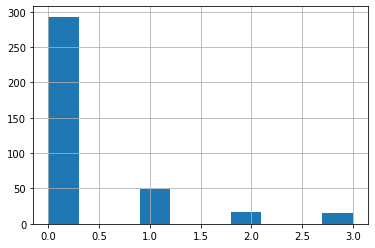

In [50]:
stud['failures'].hist()

### famrel

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [51]:
column_content_analysis(['famrel'])

------------------------------------------------------------
|	 Отчет по колонке [ famrel ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 368 из 395
|  Отсутсвующие значения: 27
|  Полнота данных: 93.16%
|  Количество уникальных значений: 6
|  Значений, встретившихся в столбце более 10 раз: 4
|  IQR: 1.0; границы выбросов: [2.5; 6.5]
|  Данные СОДЕРЖАТ выбросы, количество значений:  25
|    Слева  от IQR (уникальные): [-1.  2.  1.]
|
|  Все уникальные значения: [ 4.  5.  3. nan -1.  2.  1.] 



In [52]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['famrel'].value_counts()))

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


In [53]:
stud['famrel'].describe()

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

* Колонка содержит пустые значения - 27 шт. 
* Качество данных нормальное.
* Обнаружен выброс данных, за пределами допустимого со значением `-1`. Возможно опечатка (лишний минус).
* Уникальные значения в пределах начальных условий.

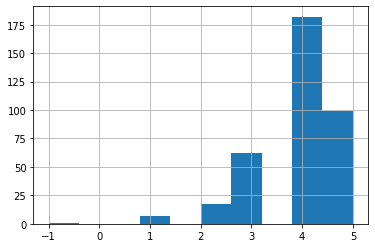

In [54]:
stud['famrel'].hist()

### freetime

freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [55]:
column_content_analysis(['freetime'])

------------------------------------------------------------
|	 Отчет по колонке [ freetime ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 384 из 395
|  Отсутсвующие значения: 11
|  Полнота данных: 97.22%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 5
|  IQR: 1.0; границы выбросов: [1.5; 5.5]
|  Данные СОДЕРЖАТ выбросы, количество значений:  18
|    Слева  от IQR (уникальные): [1.]
|
|  Все уникальные значения: [ 3.  2.  4.  1.  5. nan] 



In [56]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['freetime'].value_counts()))

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


In [57]:
stud['freetime'].describe()

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

* Колонка содержит пустые значения - 11 шт. 
* Качество данных хорошее.
* Обнаружен выброс данных, но в пределах допустимого.
* Уникальные значения в пределах начальных условий.

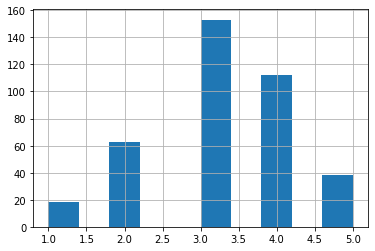

In [58]:
stud['freetime'].hist()

### goout

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [59]:
column_content_analysis(['goout'])

------------------------------------------------------------
|	 Отчет по колонке [ goout ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 387 из 395
|  Отсутсвующие значения: 8
|  Полнота данных: 97.97%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 5
|  IQR: 2.0; границы выбросов: [-1.0; 7.0]
|
|  Все уникальные значения: [ 4.  3.  2.  1.  5. nan] 



In [60]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['goout'].value_counts()))

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


In [61]:
stud['goout'].describe()

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

* Колонка содержит пустые значения - 8 шт. 
* Качество данных хорошее.
* Выбросов данных не обнаружено.
* Уникальные значения в пределах начальных условий.

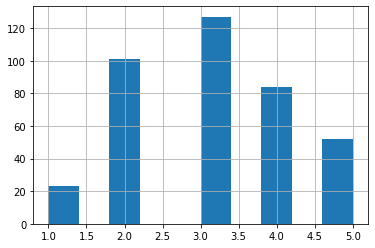

In [62]:
stud['goout'].hist()

### health

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [63]:
column_content_analysis(['health'])

------------------------------------------------------------
|	 Отчет по колонке [ health ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 380 из 395
|  Отсутсвующие значения: 15
|  Полнота данных: 96.2%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 5
|  IQR: 2.0; границы выбросов: [0.0; 8.0]
|
|  Все уникальные значения: [ 3.  5.  1.  2.  4. nan] 



In [64]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['health'].value_counts()))

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


In [65]:
stud['health'].describe()

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

* Колонка содержит пустые значения - 15 шт. 
* Качество данных хорошее.
* Данные не содержат выбросов.
* Уникальные значения в пределах начальных условий.

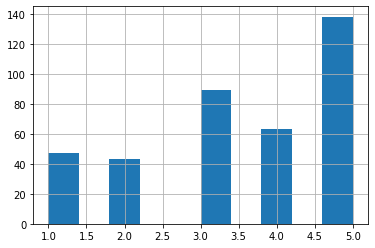

In [66]:
stud['health'].hist()

### absences

absences — количество пропущенных занятий

In [67]:
column_content_analysis(['absences'])

------------------------------------------------------------
|	 Отчет по колонке [ absences ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 383 из 395
|  Отсутсвующие значения: 12
|  Полнота данных: 96.96%
|  Количество уникальных значений: 36
|  Значений, встретившихся в столбце более 10 раз: 8
|  IQR: 8.0; границы выбросов: [-12.0; 20.0]
|  Данные СОДЕРЖАТ выбросы, количество значений:  17
|    Справа от IQR (уникальные): [ 25.  54.  26.  56.  24.  28.  22. 385.  21.  75.  30.  38.  40.  23.
 212.]
|
|  Все уникальные значения: [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
  26.  20.  56.  24.  28.   5.  13.  15.  22.   3. 385.  21.   1.  75.
  30.  19.   9.  11.  38.  40.  23.  17. 212.] 



In [132]:
# посмотрим на содержимое столбца и количество значений
display(pd.DataFrame(stud['absences'].value_counts()).sort_index(ascending=False))

,absences
385.0,1
212.0,1
75.0,1
56.0,1
54.0,1
40.0,1
38.0,1
30.0,1
28.0,1
26.0,1


In [69]:
stud['absences'].describe()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

* Колонка содержит пустые значения - 12 шт. 
* Качество данных приемлемое.
* Обнаружен сильный выброс данных, значения `385` и `212` - явно аномальные, поэтому будут исключены.

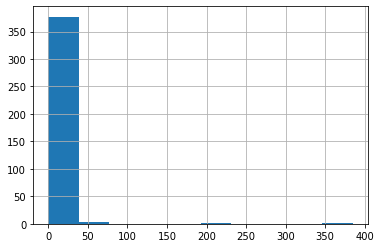

In [70]:
stud['absences'].hist()

### score

score — баллы по госэкзамену по математике

In [133]:
column_content_analysis(['score'])

------------------------------------------------------------
|	 Отчет по колонке [ score ] 					
------------------------------------------------------------
|  Тип данных: float64
|  Заполнено значений: 389 из 395
|  Отсутсвующие значения: 6
|  Полнота данных: 98.48%
|  Количество уникальных значений: 18
|  Значений, встретившихся в столбце более 10 раз: 12
|  Медиана:  55.0
|  IQR: 30.0; границы выбросов: [-5.0; 115.0]
|---
|  Все уникальные значения: [ 30.  50.  75.  55.  95.  45.  60.  70.  80.  25.  40.  85.  90.  65.
 100.  35.   0.  nan  20.] 



In [136]:
# посмотрим на содержимое столбца и количество значений
score_df = pd.DataFrame(stud['score'].value_counts())
score_df.sort_index()

,score
0.0,37
20.0,1
25.0,7
30.0,15
35.0,9
40.0,31
45.0,27
50.0,54
55.0,46
60.0,31


* 37 учеников получили 0 баллов, 1 ученик получил максимальный балл: 100
* среднее значение 52.3

*Ремарка:*
* менее 27 баллов получили 45 учеников, если применить минимальный балл по ЕГЭ по РФ, то эти ученики предположительно не набрали пороговый балл для аттестата.

In [73]:
stud['score'].describe()

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

* Колонка содержит пустые значения - 6 шт. 
* Качество данных хорошее. Распределние баллов показывает, что используется 100-бальная шкала оценок.
* Выбросы данных не обнаружены.
* Уникальные значения в пределах начальных условий.


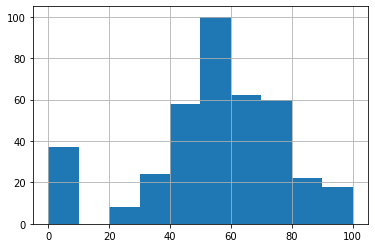

In [74]:
stud['score'].hist()

Выводы по результатам осмотра данных - сделующие столбцы требуют дополнительной обработки:

*   `fedu` - корректировка значения
*   `absences` - устранение выбросов

Почти все столбцы (кроме `age`) имеют пропуски данных, поэтому строки с пропусками будут исключены из анализа.

Топ 3 столбцов - лидеров по пропуску данных:
* `traveltime`
* `famrel`
* `fedu`

## Распределение признака для строковых переменных

In [76]:
# количество текстовых столбцов
len(other_columns)

17

In [77]:
# список текстовых столбцов
other_columns

['school',
 'sex',
 'address',
 'famsize',
 'pstatus',
 'mjob',
 'fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [78]:
# список и расширенная информация для стоковых столбцов
stud.loc[:, other_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   address     378 non-null    object
 3   famsize     368 non-null    object
 4   pstatus     350 non-null    object
 5   mjob        376 non-null    object
 6   fjob        359 non-null    object
 7   reason      378 non-null    object
 8   guardian    364 non-null    object
 9   schoolsup   386 non-null    object
 10  famsup      356 non-null    object
 11  paid        355 non-null    object
 12  activities  381 non-null    object
 13  nursery     379 non-null    object
 14  higher      375 non-null    object
 15  internet    361 non-null    object
 16  romantic    364 non-null    object
dtypes: object(17)
memory usage: 52.6+ KB


### school

school — аббревиатура школы, в которой учится ученик

In [79]:
column_content_analysis(['school'])

------------------------------------------------------------
|	 Отчет по колонке [ school ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['GP' 'MS'] 



In [80]:
stud['school'].describe()

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

In [81]:
# посмотрим на содержимое столбца
display(pd.DataFrame(stud['school'].value_counts()))

,school
GP,349
MS,46


### sex

sex — пол ученика ('F' - женский, 'M' - мужской)

In [82]:
column_content_analysis(['sex'])
stud['sex'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ sex ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 395 из 395
|  Отсутсвующие значения: 0
|  Полнота данных: 100.0%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['F' 'M'] 



count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

In [83]:
display(pd.DataFrame(stud['sex'].value_counts()))

,sex
F,208
M,187


### address

address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [84]:
column_content_analysis(['address'])
stud['address'].describe()


------------------------------------------------------------
|	 Отчет по колонке [ address ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 378 из 395
|  Отсутсвующие значения: 17
|  Полнота данных: 95.7%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['U' None 'R'] 



count     378
unique      2
top         U
freq      295
Name: address, dtype: object

In [85]:
display(pd.DataFrame(stud['address'].value_counts()))

,address
U,295
R,83


### famsize

famsize — размер семьи('LE3' <= 3, 'GT3' >3)

In [86]:
# famsize
column_content_analysis(['famsize'])
stud['famsize'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ famsize ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 368 из 395
|  Отсутсвующие значения: 27
|  Полнота данных: 93.16%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: [None 'GT3' 'LE3'] 



count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

In [87]:
display(pd.DataFrame(stud['famsize'].value_counts()))

,famsize
GT3,261
LE3,107


### pstatus

pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [88]:
# pstatus
column_content_analysis(['pstatus'])
stud['pstatus'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ pstatus ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 350 из 395
|  Отсутсвующие значения: 45
|  Полнота данных: 88.61%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['A' None 'T'] 



count     350
unique      2
top         T
freq      314
Name: pstatus, dtype: object

In [89]:
display(pd.DataFrame(stud['pstatus'].value_counts()))

,pstatus
T,314
A,36


### mjob

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [90]:
# mjob
column_content_analysis(['mjob'])
stud['mjob'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ mjob ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 376 из 395
|  Отсутсвующие значения: 19
|  Полнота данных: 95.19%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 5
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['at_home' 'health' 'other' 'services' 'teacher' None] 



count       376
unique        5
top       other
freq        133
Name: mjob, dtype: object

In [91]:
display(pd.DataFrame(stud['mjob'].value_counts()))

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


### fjob

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [92]:
# fjob
column_content_analysis(['fjob'])
stud['fjob'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ fjob ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 359 из 395
|  Отсутсвующие значения: 36
|  Полнота данных: 90.89%
|  Количество уникальных значений: 5
|  Значений, встретившихся в столбце более 10 раз: 5
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['teacher' 'other' None 'health' 'services' 'at_home'] 



count       359
unique        5
top       other
freq        197
Name: fjob, dtype: object

In [93]:
display(pd.DataFrame(stud['fjob'].value_counts()))

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


### reason

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [94]:
# reason
column_content_analysis(['reason'])
stud['reason'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ reason ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 378 из 395
|  Отсутсвующие значения: 17
|  Полнота данных: 95.7%
|  Количество уникальных значений: 4
|  Значений, встретившихся в столбце более 10 раз: 4
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['course' 'other' 'home' 'reputation' None] 



count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

In [95]:
display(pd.DataFrame(stud['reason'].value_counts()))

,reason
course,137
home,104
reputation,103
other,34


### guardian

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [96]:
# guardian
column_content_analysis(['guardian'])
stud['guardian'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ guardian ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 364 из 395
|  Отсутсвующие значения: 31
|  Полнота данных: 92.15%
|  Количество уникальных значений: 3
|  Значений, встретившихся в столбце более 10 раз: 3
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['mother' 'father' 'other' None] 



count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

In [97]:
display(pd.DataFrame(stud['guardian'].value_counts()))

,guardian
mother,250
father,86
other,28


### schoolsup

schoolsup — дополнительная образовательная поддержка (yes или no)

In [98]:
# schoolsup
column_content_analysis(['schoolsup'])
stud['schoolsup'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ schoolsup ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 386 из 395
|  Отсутсвующие значения: 9
|  Полнота данных: 97.72%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['yes' 'no' None] 



count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

In [99]:
display(pd.DataFrame(stud['schoolsup'].value_counts()))

,schoolsup
no,335
yes,51


### famsup

famsup — семейная образовательная поддержка (yes или no)

In [100]:
# famsup
column_content_analysis(['famsup'])
stud['famsup'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ famsup ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 356 из 395
|  Отсутсвующие значения: 39
|  Полнота данных: 90.13%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['no' 'yes' None] 



count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

In [101]:
display(pd.DataFrame(stud['famsup'].value_counts()))

,famsup
yes,219
no,137


### paid

paid — дополнительные платные занятия по математике (yes или no)

In [102]:
# paid
column_content_analysis(['paid'])
stud['paid'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ paid ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 355 из 395
|  Отсутсвующие значения: 40
|  Полнота данных: 89.87%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['no' None 'yes'] 



count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

In [103]:
display(pd.DataFrame(stud['paid'].value_counts()))

,paid
no,200
yes,155


### activities

activities — дополнительные внеучебные занятия (yes или no)

In [104]:
# activities
column_content_analysis(['activities'])
stud['activities'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ activities ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 381 из 395
|  Отсутсвующие значения: 14
|  Полнота данных: 96.46%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['no' 'yes' None] 



count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

In [105]:
display(pd.DataFrame(stud['activities'].value_counts()))

,activities
yes,195
no,186


### nursery

nursery — посещал детский сад (yes или no)

In [106]:
# nursery
column_content_analysis(['nursery'])
stud['nursery'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ nursery ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 379 из 395
|  Отсутсвующие значения: 16
|  Полнота данных: 95.95%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['yes' 'no' None] 



count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

In [107]:
display(pd.DataFrame(stud['nursery'].value_counts()))

,nursery
yes,300
no,79


### higher

higher — хочет получить высшее образование (yes или no)

In [108]:
# higher
column_content_analysis(['higher'])
stud['higher'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ higher ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 375 из 395
|  Отсутсвующие значения: 20
|  Полнота данных: 94.94%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['yes' None 'no'] 



count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

In [109]:
display(pd.DataFrame(stud['higher'].value_counts()))

,higher
yes,356
no,19


### internet

internet — наличие интернета дома (yes или no)

In [110]:
# internet
column_content_analysis(['internet'])
stud['internet'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ internet ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 361 из 395
|  Отсутсвующие значения: 34
|  Полнота данных: 91.39%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: [None 'yes' 'no'] 



count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

In [111]:
display(pd.DataFrame(stud['internet'].value_counts()))

,internet
yes,305
no,56


### romantic

romantic — в романтических отношениях (yes или no)

In [112]:
# romantic
column_content_analysis(['romantic'])
stud['romantic'].describe()

------------------------------------------------------------
|	 Отчет по колонке [ romantic ] 					
------------------------------------------------------------
|  Тип данных: object
|  Заполнено значений: 364 из 395
|  Отсутсвующие значения: 31
|  Полнота данных: 92.15%
|  Количество уникальных значений: 2
|  Значений, встретившихся в столбце более 10 раз: 2
|  Количество раз пробелы найдены:
|    в начале строки: 0
|    в конце  строки: 0
|  Количество найденных специальных символов: 0
|
|  Все уникальные значения: ['no' None 'yes'] 



count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

In [113]:
display(pd.DataFrame(stud['romantic'].value_counts()))

,romantic
no,240
yes,124


## Устранение выбросов

### fedu

Посмотрим на строку с выбросом внимательней


In [139]:
stud[stud['fedu'] == 40]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,None,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Значение `40` с большой вероятностей опечатка,  предположим что должно быть значение `4`

In [144]:
# исправим ошибочное значение
stud['fedu'][stud['fedu'] == 40] = 4

#  проверим результат 
stud['fedu'].loc[11]

4.0

### absences

* Обнаружен сильный выброс данных, значения `385` и `212` - явно аномальные, поэтому будут исключены.

In [151]:
stud[stud['absences'] >= 212]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score


In [149]:
stud[stud['absences'] >= 212].index


Int64Index([222, 390], dtype='int64')

In [150]:
stud.drop(stud[stud['absences'] >= 212].index, inplace=True)

In [115]:
# for col_name in elimination:
#     left_range, right_range = column_iqr_range(col_name)
#     stud.drop(stud.loc[stud[col_name] < left_range].index, inplace=True)
#     stud.drop(stud.loc[stud[col_name] > right_range].index, inplace=True)


Проверим числовые столбцы на пустые значения и удалим такие строки.

In [158]:
stud.shape
stud.dropna('index', subset=dig_columns, inplace=True)

In [159]:
stud.shape

(261, 29)

Датасет сократился с 395 строк до 261.

## Оценка количества уникальных значений для номинативных переменных

Заполнить пропуски на данный момент не представляется возможным, так как методика не предлагается. Поэтому отбросим данные с пропусками.

### Преобразование данных

### Корреляционный анализ количественных элементов

### Отбор не коррелирующих переменных

### Анализ номинативных переменных, устранение не влияющих на предсказание конечной величины

In [116]:
# на переменную scope

### Выводы о качестве данных

### Выводы о данных, которые подходят для построения дальнейшей модели

In [117]:
### Спасибо за внимание!